In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

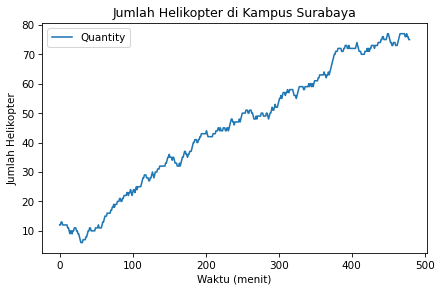

In [4]:
from modsim import *
import numpy as np

# Definisikan State awal
helicopter_shares = State(Bandung=12, Surabaya=12, Jakarta=12)

# Definisikan fungsi untuk memindahkan helikopter antar kampus
def move_helicopter():
    if flip(1/2):  # Probabilitas kedatangan mahasiswa di Bandung setiap 2 menit
        helicopter_shares['Bandung'] -= 1
        helicopter_shares['Surabaya'] += 1
    
    if flip(1/3):  # Probabilitas kedatangan mahasiswa di Surabaya setiap 3 menit
        helicopter_shares['Surabaya'] -= 1
        helicopter_shares['Jakarta'] += 1
    
    if flip(1/5):  # Probabilitas kedatangan mahasiswa di Jakarta setiap 5 menit
        helicopter_shares['Jakarta'] -= 1
        helicopter_shares['Bandung'] += 1

# Buat TimeSeries untuk merekam perubahan jumlah helikopter di kampus Surabaya
helicopter_surabaya = TimeSeries()

# Jalankan simulasi selama 8 jam (480 menit)
for i in range(480):
    move_helicopter()
    helicopter_surabaya[i] = helicopter_shares['Surabaya']

# Plot hasilnya
helicopter_surabaya.plot()

# Tambahkan dekorasi pada plot
decorate(title='Jumlah Helikopter di Kampus Surabaya',
         xlabel='Waktu (menit)', 
         ylabel='Jumlah Helikopter')

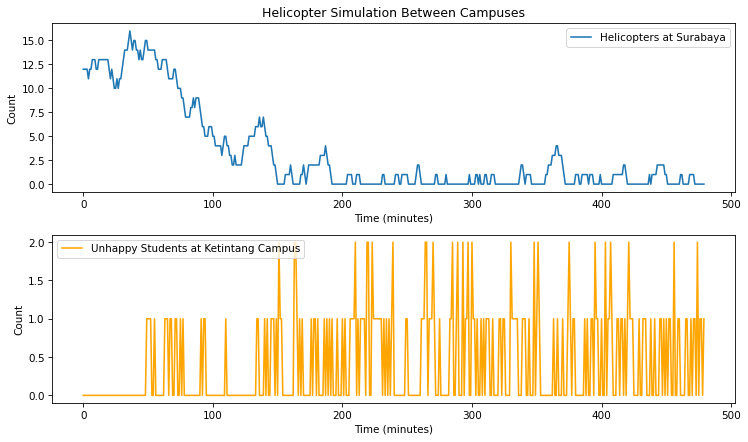

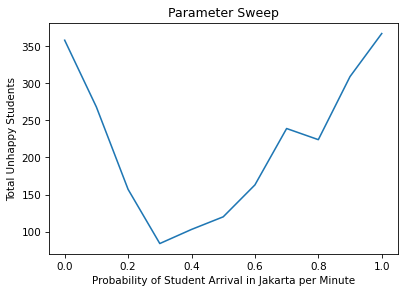

In [5]:
from modsim import *
import numpy as np
import matplotlib.pyplot as plt

def relocate_helicopter(state, p1, p2, p3):
    """Relocate helicopters between campuses based on student arrival probabilities.

    Parameters:
        state : State
            State containing the number of helicopters at each campus.
        p1 : float
            Probability of student arrivals in Bandung per minute.
        p2 : float
            Probability of student arrivals in Surabaya per minute.
        p3 : float
            Probability of student arrivals in Jakarta per minute.
    
    Returns:
        int
            Number of students who are unhappy due to helicopter shortage at Ketintang campus.
    """
    unhappy_students = 0

    if flip(p1):  # Probability of student arrivals in Bandung per minute
        if state['Bandung'] > 0:
            state['Bandung'] -= 1
            state['Surabaya'] += 1
        else:
            unhappy_students += 1
    
    if flip(p2):  # Probability of student arrivals in Surabaya per minute
        if state['Surabaya'] > 0:
            state['Surabaya'] -= 1
            state['Jakarta'] += 1
        else:
            unhappy_students += 1
    
    if flip(p3):  # Probability of student arrivals in Jakarta per minute
        if state['Jakarta'] > 0:
            state['Jakarta'] -= 1
            state['Bandung'] += 1
        else:
            unhappy_students += 1

    return unhappy_students

def simulate(p1, p2, p3):
    """Run simulation for 8 hours (480 minutes) and record changes in helicopter count at Surabaya campus and number of unhappy students.

    Parameters:
        p1 : float
            Probability of student arrivals in Bandung per minute.
        p2 : float
            Probability of student arrivals in Surabaya per minute.
        p3 : float
            Probability of student arrivals in Jakarta per minute.
    
    Returns:
        TimeSeries
            TimeSeries containing the number of helicopters at Surabaya campus per minute.
        TimeSeries
            TimeSeries containing the number of unhappy students due to helicopter shortage at Ketintang campus per minute.
    """
    state = State(Bandung=12, Surabaya=12, Jakarta=12)
    helicopters_surabaya = TimeSeries()
    unhappy_students = TimeSeries()

    for i in range(480):  # Simulate for 8 hours (480 minutes)
        unhappy_students_this_minute = relocate_helicopter(state, p1, p2, p3)
        helicopters_surabaya[i] = state['Surabaya']
        unhappy_students[i] = unhappy_students_this_minute

    return helicopters_surabaya, unhappy_students

def plot_simulation(helicopters_surabaya, unhappy_students):
    """Plot simulation results.

    Parameters:
        helicopters_surabaya : TimeSeries
            TimeSeries containing the number of helicopters at Surabaya campus per minute.
        unhappy_students : TimeSeries
            TimeSeries containing the number of unhappy students due to helicopter shortage at Ketintang campus per minute.
    """
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(helicopters_surabaya, label='Helicopters at Surabaya')
    plt.title('Helicopter Simulation Between Campuses')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(unhappy_students, label='Unhappy Students at Ketintang Campus', color='orange')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

def parameter_sweep():
    """Perform parameter sweep to observe the relationship between student arrival time and number of unhappy students."""
    p_values = linspace(0, 1, 11)
    sweep_results = SweepSeries()

    for p in p_values:
        helicopters_surabaya, unhappy_students = simulate(0.5, 0.33, p)
        total_unhappy_students = sum(unhappy_students)  # Total number of unhappy students
        sweep_results[p] = total_unhappy_students

    plt.plot(sweep_results)
    plt.title('Parameter Sweep')
    plt.xlabel('Probability of Student Arrival in Jakarta per Minute')
    plt.ylabel('Total Unhappy Students')
    plt.show()

# Run simulation with default probability values (0.5, 0.33, 0.2)
helicopters_surabaya, unhappy_students = simulate(0.5, 0.33, 0.2)

# Plot simulation results
plot_simulation(helicopters_surabaya, unhappy_students)

# Perform parameter sweep
parameter_sweep()


In [6]:
def heli_to_gayungan(state):
    """Move one helicopter from Benowo to Gayungan.
    
    state: helishare State object
    """

    if flip(0.7):
        if state.benowo == 0:
            state.all_unhappy += 1
            return

        state.benowo -= 1
        state.gayungan += 1


def heli_to_ketintang(state):
    """Move one helicopter from Ketintang to Gayungan.
    
    state: helishare State object
    """    
    if flip(0.6):
        if state.ketintang == 0:
            state.ketintang_empty += 1
            state.all_unhappy += 1
            return
        state.ketintang -= 1
        state.gayungan += 1

    
def heli_to_ketintang(state):
    """Move one helicopter from Benowo to Ketintang.
    
    state: helishare State object
    """
    if flip(0.4):
        if state.benowo == 0:
            state.all_unhappy += 1
            return
        state.benowo -= 1
        state.ketintang += 1


def heli_to_gayungan(state):
    """Move one helicopter from Gayungan to Ketintang.
    
    state: helishare State object
    """
    if flip(0.3):
        if state.gayungan == 0:
            state.all_unhappy += 1
            return
        state.gayungan -= 1
        state.ketintang += 1


def heli_to_benowo(state):
    """Move one helicopter from Gayungan to Benowo.
    
    state: helishare State object
    """
    if flip(0.7):
        if state.gayungan == 0:
            state.all_unhappy += 1
            return
        state.gayungan -= 1
        state.benowo += 1

    """Move one helicopter from Ketintang to Benowo.
    
    state: helishare State object
    """
    if flip(0.5):
        if state.ketintang == 0:
            state.ketintang_empty += 1
            state.all_unhappy += 1
            return
        state.ketintang -= 1
        state.benowo += 1

In [7]:
def fly(state, p1, p2, p3):
    """Simulate one time fly.
    
    state: helishare State object
    p1: probability of a helicopter flying to Gayungan
    p2: probability of a helicopter flying to Ketintang
    p3: probability of a helicopter flying to Benowo
    """
    if flip(p1):
        heli_to_gayungan(state)
    
    if flip(p2):
        heli_to_ketintang(state)

    if flip(p3):
        heli_to_benowo(state)

In [8]:
def run_simulation2(state, p1, p2, p3, times, label):
    
    """Simulate the given number of times flying.
    
    state: helishare State object
    p1: probability of a helicopter flying to Gayungan
    p2: probability of a helicopter flying to Ketintang
    p3: probability of a helicopter flying to Benowo
    times: number of times flying
    """
    results = TimeSeries()
    for i in range(times):
        fly(state, p1, p2, p3)
        results[i + 1] = state.ketintang

    results.plot(label=label)
    decorate(title='Gayungan-Ketintang-Benowo helishare',
         xlabel='Jam', 
         ylabel='Jumlah helikopter di Ketintang')

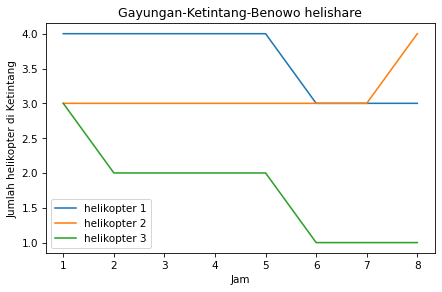

In [9]:
from numpy import linspace

helishare = State(gayungan=14, ketintang=4, benowo=18, 
            ketintang_empty = 0,  all_unhappy = 0)
p1_array = linspace(0, 0.3, 3)
p2 = 0.3
p3 = 0.5
times = 8
sweep = SweepSeries()
i = 1
for p1 in p1_array:
    label = 'helikopter ' + str(i)
    final_state = run_simulation2(helishare, p1, p2, p3, times, label)
    sweep[p1] = helishare.ketintang_empty
    i += 1

In [10]:
show(helishare)


,state
gayungan,5
ketintang,1
benowo,30
ketintang_empty,0
all_unhappy,0


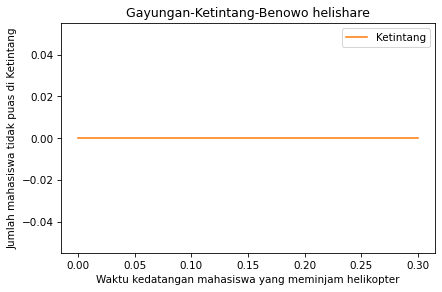

In [11]:
sweep.plot(label='Ketintang', color='C1')
decorate(title='Gayungan-Ketintang-Benowo helishare',
        xlabel='Waktu kedatangan mahasiswa yang meminjam helikopter', 
        ylabel='Jumlah mahasiswa tidak puas di Ketintang')

In [12]:
show(sweep)

,Metric
Parameter,
0.00,0
0.15,0
0.30,0
